### Import modules

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import os


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



/home/skyriver/anaconda3/envs/medimg/lib/python3.12/site-packages/IPython/core/completerlib.py:150: UserWarning: This is now an optional IPython functionality, setting rootmodules_cache requires you to install the `pickleshare` library.
  ip.db['rootmodules_cache'] = rootmodules_cache


### Import data

In [2]:
# read Input/Task1/rawMRData_Imag.npy
rawMRData_Imag = np.load('Input/Task1/rawMRData_Imag.npy')

# read Input/Task1/rawMRData_Real.npy
rawMRData_Real = np.load('Input/Task1/rawMRData_Real.npy')

### Task 1.1
![image](Input/Task1/task1_1.png)

- $k_i$, $k_j$ 는 각 k-space에서의 2차원 좌표를 의미할 것이고 l은 slice에 대한 데이터 확인할 수 있다.

In [3]:
print(f"rawMRData_Imag shape: {rawMRData_Imag.shape}")
print(f"rawMRData_Real shape: {rawMRData_Real.shape}")

rawMRData_Imag shape: (384, 512, 36)
rawMRData_Real shape: (384, 512, 36)


In [6]:
rawMRData = rawMRData_Real + 1j * rawMRData_Imag
print(f"rawMRData shape: {rawMRData.shape}")
print(f"rawMRData dtype: {rawMRData.dtype}")
print(f"rawMRData[0,0,0]: {rawMRData[0,0,0]}")

rawMRData shape: (384, 512, 36)
rawMRData dtype: complex128
rawMRData[0,0,0]: (-231+0j)


In [21]:
ind_l = 22
target_MRData = 20*np.abs(rawMRData[:,:,ind_l])

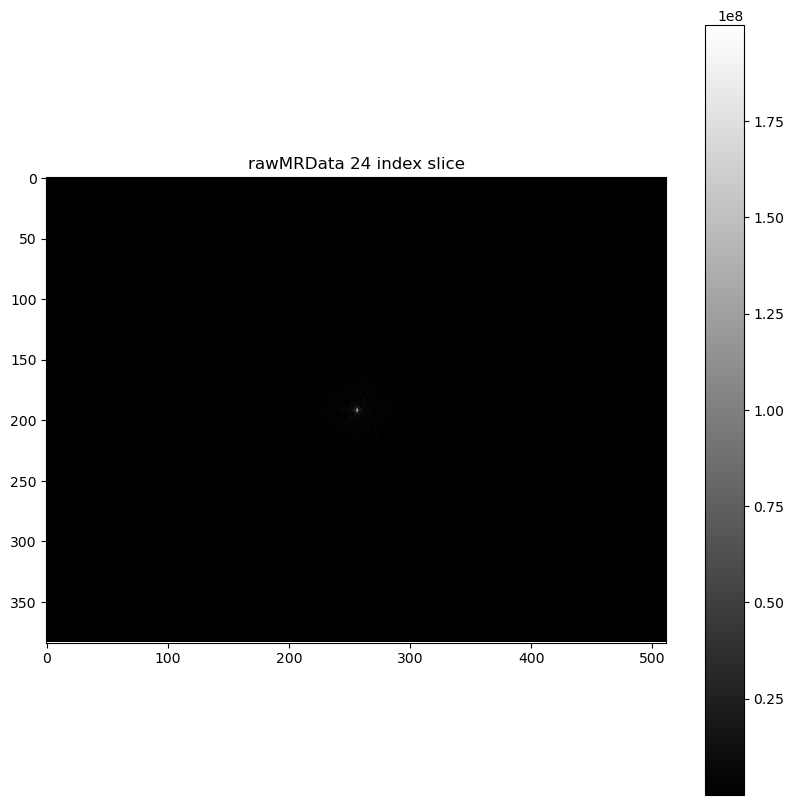

In [22]:
#plot target_MRData
plt.figure(figsize=(10,10))
plt.title('rawMRData 24 index slice')
plt.imshow(target_MRData, cmap='gray')
plt.colorbar()
plt.show()

### Task 1.2.
![image](Input/Task1/task1_2.png)

**생각) rawMRData를 x,y 좌표로 변환하는 것을 목표로 보임**
1. fftshift 적용
2. inverse 2D Fourier transform
3. 복소 내용에 대해서는 크기로 변환
4. dx, dy를 7.422 * 10**-1 로 간주해 하나를 노출

**FFTshift**
NumPy의 fftshift 함수 사용
- 주파수 도메인에서 FFT(고속 푸리에 변환) 결과를 시간 도메인으로 변환

fftshift 함수는 배열의 축을 따라 이동시키는데, 이동은 배열의 중앙을 기준으로 진행
- 2차원 배열의 경우, 배열의 첫 번째 절반은 마지막 행과 열로 이동하고, 끝 절반은 첫 번째 행과 열로 이동합니다.

이 코드에서는 rawMRData 배열을 (0,1) 축을 기준으로 이동시킵니다. 이는 2차원 배열에서 첫 번째 축(행)과 두 번째 축(열)을 기준으로 이동


- 기본적으로 fft를 수행한 결과물일 것이기 때문에, 영주파수 성분이 (0,0)에 위치하게되며, 실제로도 그러한것을 위해서 확인했다.
    - 이에, 영주파수 성분을 이미지의 중앙으로 옮기는 것이 타당하다.

In [23]:
# fftshift & inverse 2d ft
fftshift_rawMRData = np.zeros(rawMRData.shape, dtype=complex)
for i in range(rawMRData.shape[2]):
    fftshift_rawMRData_i = np.fft.fftshift(rawMRData[:,:,i])
    fftshift_rawMRData[:,:,i] = fftshift_rawMRData_i

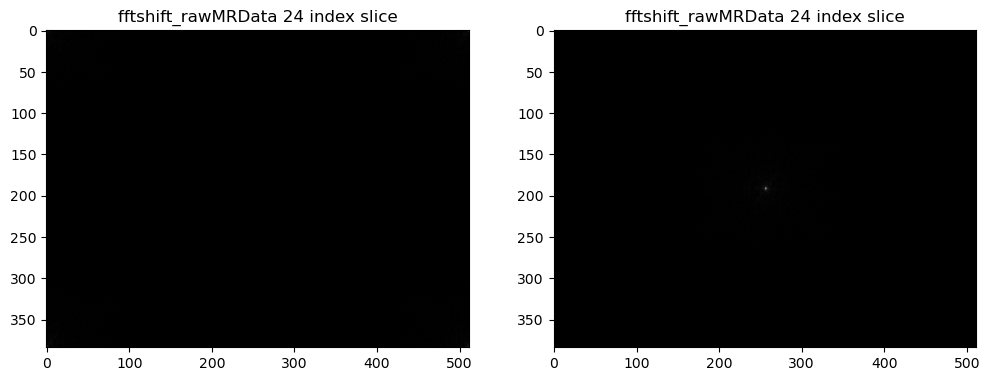

In [24]:
#plot fftshift_rawMRData
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('fftshift_rawMRData 24 index slice')
plt.imshow(np.abs(fftshift_rawMRData[:,:,ind_l]), cmap='gray')
plt.subplot(122)
plt.title('fftshift_rawMRData 24 index slice')
plt.imshow(target_MRData, cmap='gray')

In [43]:
# fftshift & inverse 2d ft
MRData_l = []
for i in range(rawMRData.shape[2]):
    MRData_i = np.abs(np.fft.ifft2(np.fft.fftshift(rawMRData[:,:,i])))
    MRData_l.append(MRData_i)
MRData = np.dstack(MRData_l)

In [44]:
print(f"MRData dtype: {MRData.dtype}")

MRData dtype: float64


In [45]:
dx = 7.422*10**(-2)
dy = 7.422*10**(-2)
x = dx*MRData.shape[1]
y = dy*MRData.shape[0]
print(f"x: {x}cm, y: {y}cm")

x: 38.00064cm, y: 28.500479999999996cm


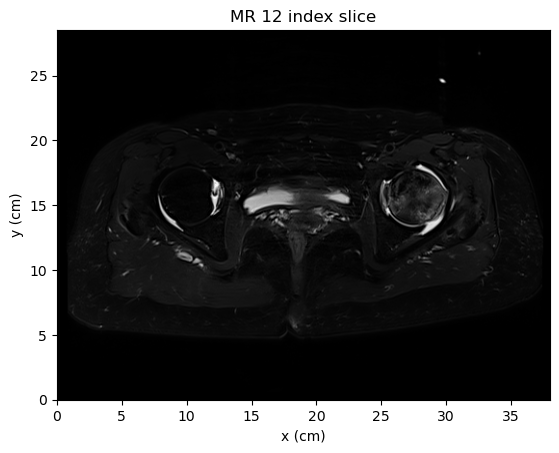

In [49]:
plt.title('MR 12 index slice')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.imshow(MRData[:,:,12], cmap='gray', extent=[0,x,0,y])

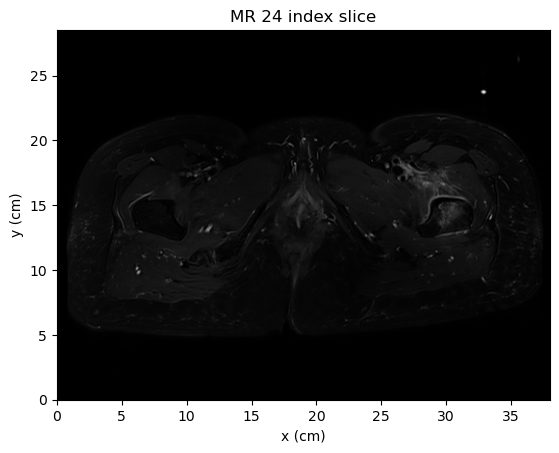

In [50]:
plt.title('MR 24 index slice')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.imshow(MRData[:,:,24], cmap='gray', extent=[0,x,0,y])

### Task 1.3
![image](Input/Task1/task1_3.png)

In [54]:
mr_slice_0 = pydicom.dcmread('Input/Task1/blind/000000.dcm')
mr_slice_1 = pydicom.dcmread('Input/Task1/blind/000001.dcm')
print(f"mr_slice_0 shape: {mr_slice_0.pixel_array.shape}")

mr_slice_0 shape: (384, 512)


In [55]:
mr_slice_0

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 226
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.115555597611170282812212243341817248873
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.3.100.9.4
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 9.4'
(0002, 0016) Source Application Entity Title     AE: 'MAROTECH'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'WATER', 'NORM', 'DIS2D', 'FM', 'FIL']
(0008, 0012) Instance Creation Date              DA: '20180528'
(0008, 0013) Instance Creation Time     

In [57]:
meta_data_atr_l = mr_slice_0.dir()
meta_data_dict = dict(zip(meta_data_atr_l, [getattr(mr_slice_0, atr) for atr in meta_data_atr_l]))

In [60]:
meta_data_atr_l

['AccessionNumber',
 'AcquisitionDate',
 'AcquisitionMatrix',
 'AcquisitionNumber',
 'AcquisitionTime',
 'AngioFlag',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ContentDate',
 'ContentTime',
 'DeviceSerialNumber',
 'EchoNumbers',
 'EchoTime',
 'EchoTrainLength',
 'FlipAngle',
 'FrameOfReferenceUID',
 'HighBit',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'ImageType',
 'ImagedNucleus',
 'ImagingFrequency',
 'InPlanePhaseEncodingDirection',
 'InstanceCreationDate',
 'InstanceCreationTime',
 'InstanceNumber',
 'InstitutionAddress',
 'InstitutionName',
 'InstitutionalDepartmentName',
 'LargestImagePixelValue',
 'Laterality',
 'MRAcquisitionType',
 'MagneticFieldStrength',
 'Manufacturer',
 'ManufacturerModelName',
 'Modality',
 'NumberOfAverages',
 'NumberOfPhaseEncodingSteps',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientPosition',
 'PatientSex',
 'PatientSize',
 'PatientWeight',
 'PercentPhaseFieldOfView',
 'PercentSampling

In [61]:
# get meta data dict with key containing 'Patient'
meta_data_dict_patient = {k: v for k, v in meta_data_dict.items() if 'Patient' in k}
meta_data_dict_patient

{'ImageOrientationPatient': [0.99849988464, 0.0505904583633, -0.0209424424677, -0.0506015523881, 0.9987189208661, 1.79566775E-07],
 'ImagePositionPatient': [-192.73852321101, -101.49106053552, 53.941851162488],
 'PatientAge': '057Y',
 'PatientBirthDate': '19610116',
 'PatientID': '000000000',
 'PatientName': 'XXX^XXX',
 'PatientPosition': 'HFS',
 'PatientSex': 'F',
 'PatientSize': '1.7',
 'PatientWeight': '80.0'}

- name의 가명처리를 확인할 수 있다.

In [77]:
dcm_path = 'Input/Task1/blind/'
dcm_file_l = os.listdir(dcm_path)
print(f"len(dcm_file_l): {len(dcm_file_l)}")
print(f"dcm_file_l[:5]: {dcm_file_l[:5]}")

len(dcm_file_l): 36
dcm_file_l[:5]: ['000000.dcm', '000001.dcm', '000002.dcm', '000003.dcm', '000004.dcm']


In [78]:
for ind, dcm_file in enumerate(dcm_file_l):
    dcm = pydicom.dcmread(dcm_path + dcm_file)
    if np.all(dcm.pixel_array == 0):
        print(f"processing {dcm_file} with index {ind}")
        dcm.PixelData = MRData[:,:,ind].tobytes()
        dcm.save_as(dcm_path + dcm_file)

processing 000000.dcm with index 0
processing 000001.dcm with index 1
processing 000002.dcm with index 2
processing 000003.dcm with index 3
processing 000004.dcm with index 4
processing 000005.dcm with index 5
processing 000007.dcm with index 6
processing 000006.dcm with index 7
processing 000008.dcm with index 8
processing 000009.dcm with index 9
processing 000010.dcm with index 10
processing 000011.dcm with index 11
processing 000012.dcm with index 12
processing 000013.dcm with index 13
processing 000014.dcm with index 14
processing 000015.dcm with index 15
processing 000016.dcm with index 16
processing 000017.dcm with index 17
processing 000018.dcm with index 18
processing 000019.dcm with index 19
processing 000020.dcm with index 20
processing 000021.dcm with index 21
processing 000022.dcm with index 22
processing 000023.dcm with index 23
processing 000024.dcm with index 24
processing 000025.dcm with index 25
processing 000026.dcm with index 26
processing 000027.dcm with index 27
pr

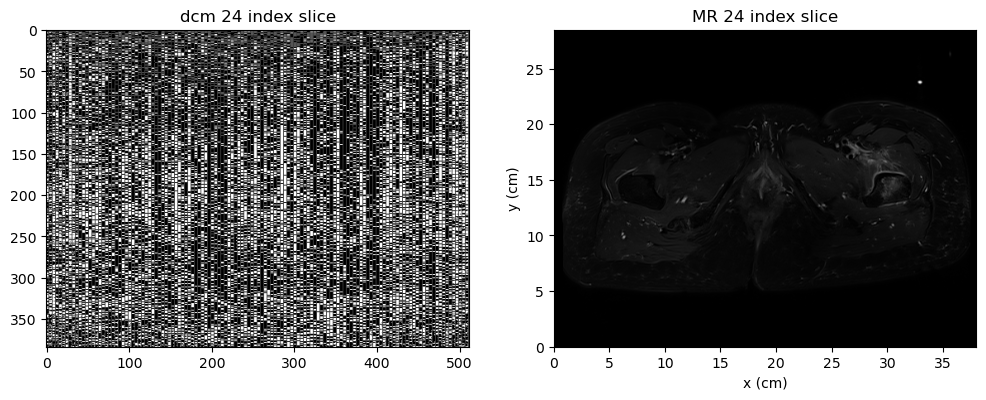

In [79]:
# draw dcm file's 24 index slice
plt.figure(figsize=(12,6))
plt.subplot(121)
dcm_24 = pydicom.dcmread(dcm_path + dcm_file_l[24])
plt.title('dcm 24 index slice')
plt.imshow(dcm_24.pixel_array, cmap='gray')
plt.subplot(122)
plt.title('MR 24 index slice')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.imshow(MRData[:,:,24], cmap='gray', extent=[0,x,0,y])
plt.show()